# パッケージ


In [1]:
import pandas as pd
import re
import os
from typing import Literal
from tqdm import tqdm
import pickle
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import glob
import pickle
from sklearn.preprocessing import StandardScaler

# 次元圧縮モデル作成


## 過去成績の集計


In [17]:
class PedigreeSireProcessor:
    def __init__(self, path) -> None:
        df = pd.read_pickle(path)
        self.sire_results_raw = df["sire_results"]
        self.sire_course_raw = df["sire_course"]
        self.sire_distance_raw = df["sire_distance"]
        # 整形
        try:
            self.sire_results = self.adjust(self.sire_results_raw["sire_results"])
        except:
            self.sire_results = pd.read_pickle("../template/sire_results.pkl")
        try:
            self.sire_results_bms = self.adjust(
                self.sire_results_raw["sire_results_BMS"]
            )
        except:
            self.sire_results_bms = pd.read_pickle("../template/sire_results_BMS.pkl")
        try:
            self.sire_course = self.adjust(self.sire_course_raw[0])
        except:
            self.sire_course = pd.read_pickle("../template/sire_course.pkl")
        try:
            self.sire_course_bms = self.adjust(self.sire_course_raw[1])
        except:
            self.sire_course_bms = pd.read_pickle("../template/sire_course_BMS.pkl")
        try:
            self.sire_distance = self.adjust(self.sire_distance_raw[0])
        except:
            self.sire_distance = pd.read_pickle("../template/sire_distance.pkl")
        try:
            self.sire_distance_bms = self.adjust(self.sire_distance_raw[1])
        except:
            self.sire_distance_bms = pd.read_pickle("../template/sire_distance_BMS.pkl")

    def adjust(self, df: pd.DataFrame) -> pd.DataFrame:
        """dfのカラム名の整形をする

        Args:
            df (pd.DataFrame): 変換前データ

        Returns:
            pd.DataFrame: 変換後データ
        """
        df.rename(columns=lambda x: re.sub(r"\s", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"_", "", x), inplace=True)
        df.rename(columns=lambda x: re.sub(r"^(.*)\1$", r"\1", x), inplace=True)
        return df

    def translate_results(self) -> pd.DataFrame:
        """成績データの整形をする

        Returns:
            pd.DataFrame: 変換後データ
        """
        dfs = []
        for i, df in enumerate([self.sire_results, self.sire_results_bms]):
            df = df.copy()
            df.drop(columns=["年度", "順位", "勝馬率", "代表馬"], axis=1, inplace=True)
            df2 = pd.DataFrame(df.mean()).T
            df2["len"] = len(df)
            df2 = df2.add_prefix(f"{i+1}_")
            dfs.append(df2)
        return pd.concat(dfs, axis=1)

    def translate_course(self) -> pd.DataFrame:
        """成績データの整形をする

        Returns:
            pd.DataFrame: 変換後データ
        """
        dfs = []
        for i, df in enumerate([self.sire_course, self.sire_course_bms]):
            df = df.copy()
            df.drop(columns=["年度"], axis=1, inplace=True)
            df2 = pd.DataFrame(df.mean()).T
            df2["len"] = len(df)
            df2 = df2.add_prefix(f"{i+1}_")
            dfs.append(df2)
        return pd.concat(dfs, axis=1)

    def translate_distance(self) -> pd.DataFrame:
        """成績データの整形をする

        Returns:
            pd.DataFrame: 変換後データ
        """
        dfs = []
        for i, df in enumerate([self.sire_distance, self.sire_distance_bms]):
            df = df.copy()
            df.drop(columns=["年度"], axis=1, inplace=True)
            df2 = pd.DataFrame(df.mean()).T
            df2["len"] = len(df)
            df2 = df2.add_prefix(f"{i+1}_")
            dfs.append(df2)
        return pd.concat(dfs, axis=1)

    def translate(self) -> pd.DataFrame:
        """成績データの整形をする

        Returns:
            pd.DataFrame: _description_
        """
        dfs = [
            self.translate_results(),
            self.translate_course(),
            self.translate_distance(),
        ]
        return pd.concat(dfs, axis=1)

In [3]:
path = "../Raw-Data/Pedigree-Results/000a0128f6.pickle"
path = "../Raw-Data/Pedigree-Results/000a001bd6.pickle"
test = PedigreeSireProcessor(path)
df = test.translate()

In [12]:
dir_list = os.listdir("../Raw-Data/Pedigree/")
dfs = []
for data in tqdm(dir_list):
    save_path = f"../Processed-Data/Pedigree-Results/{data}"
    peds = pd.read_pickle(f"../Raw-Data/Pedigree/{data}")
    for i, ped in enumerate(peds):
        try:
            path = f"../Raw-Data/Pedigree-Results/{ped}.pickle"
            sire = PedigreeSireProcessor(path)
            df_sire = sire.translate()
            dfs.append(df_sire)
        except Exception as e:
            print(path)
            raise e
df_all = pd.concat(dfs)
df_all

100%|██████████| 49160/49160 [11:58<00:00, 68.46it/s]


,1_出走頭数,1_勝馬頭数,1_出走回数,1_勝利回数,1_重賞出走,1_重賞勝利,1_特別出走,1_特別勝利,1_平場出走,1_平場勝利,...,2_-2600(ダート)着外,2_2600-(ダート)1着,2_2600-(ダート)2着,2_2600-(ダート)3着,2_2600-(ダート)着外,2_障害1着,2_障害2着,2_障害3着,2_障害着外,2_len
0,165.473684,45.631579,707.105263,61.210526,48.684211,2.894737,195.421053,16.789474,463.000000,41.526316,...,3.000000,0.0,0.0,0.0,0.0,1.933333,0.933333,1.866667,12.933333,15
0,35.700000,10.300000,197.500000,13.000000,6.000000,0.100000,44.100000,2.300000,147.400000,10.600000,...,0.461538,0.0,0.0,0.0,0.0,0.730769,0.538462,0.269231,2.346154,26
0,147.347826,36.652174,718.869565,48.260870,42.043478,2.086957,170.000000,12.260870,506.826087,33.913043,...,3.090909,0.0,0.0,0.0,0.0,2.136364,2.363636,2.090909,22.045455,22
0,103.666667,40.277778,555.333333,58.555556,36.944444,3.388889,181.888889,19.611111,336.500000,35.555556,...,3.172414,0.0,0.0,0.0,0.0,2.172414,1.586207,1.551724,14.724138,29
0,89.473684,19.894737,377.315789,24.421053,11.368421,0.631579,69.736842,4.263158,296.210526,19.526316,...,0.312500,0.0,0.0,0.0,0.0,0.125000,0.062500,0.000000,1.812500,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3.411765,0.941176,13.764706,1.176471,0.176471,0.000000,5.941176,0.529412,7.647059,0.647059,...,0.133333,0.0,0.0,0.0,0.0,0.333333,0.066667,0.066667,0.933333,15
0,2.200000,1.000000,6.400000,1.600000,0.200000,0.000000,1.800000,0.600000,4.400000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.285714,0.0,0.0,0.0,0.0,0.142857,0.000000,0.000000,0.285714,7
0,1.666667,1.000000,6.833333,1.000000,0.000000,0.000000,2.333333,0.000000,4.500000,1.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1


## 標準化

In [21]:
# 正規化モデルの作成と適用
scaler = StandardScaler()
df_all_normalized = pd.DataFrame(
    scaler.fit_transform(df_all), columns=df_all.columns, index=df_all.index
)

# 正規化モデルの保存
with open("../models/v2/pedigree_results_scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)
# 正規化されたデータの確認
print("正規化後のデータ形状:", df_all_normalized.shape)
print("\n正規化後の統計量:")
print(df_all_normalized.describe())

正規化後のデータ形状: (98320, 226)

正規化後の統計量:
             1_出走頭数        1_勝馬頭数        1_出走回数        1_勝利回数        1_重賞出走  \
count  9.832000e+04  9.832000e+04  9.832000e+04  9.832000e+04  9.832000e+04   
mean  -9.568334e-17  1.198932e-16  8.946826e-17 -7.284653e-17 -3.302665e-17   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.190520e+00 -9.738453e-01 -1.181698e+00 -9.415940e-01 -6.800892e-01   
25%   -8.269911e-01 -7.733918e-01 -8.373662e-01 -7.607286e-01 -6.000641e-01   
50%   -2.101235e-01 -3.290531e-01 -2.130918e-01 -3.387094e-01 -3.890592e-01   
75%    5.266303e-01  4.866018e-01  6.168663e-01  5.225543e-01  1.474898e-01   
max    2.609349e+00  3.321289e+00  2.548509e+00  3.324263e+00  4.013667e+00   

             1_重賞勝利        1_特別出走        1_特別勝利        1_平場出走        1_平場勝利  \
count  9.832000e+04  9.832000e+04  9.832000e+04  9.832000e+04  9.832000e+04   
mean   1.956666e-17 -7.226838e-19 -3.503210e-17  7.913388e-17 -1.569308e-16   
std    1.000005

## 保存しているデータから集計データを作成


In [3]:
with open("../models/v2/pedigree_results_scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
dir_list = os.listdir("../Raw-Data/Pedigree/")

for data in tqdm(dir_list):
    save_path = f"../Processed-Data/Pedigree-Results/{data}"
    peds = pd.read_pickle(f"../Raw-Data/Pedigree/{data}")
    if os.path.exists(save_path):
        continue
    for i, ped in enumerate(peds):
        try:
            path = f"../Raw-Data/Pedigree-Results/{ped}.pickle"
            sire = PedigreeSireProcessor(path)
            df_sire = sire.translate()

        except Exception as e:
            print(path)
            raise e

    # データの標準化
    df_sire_normalized = pd.DataFrame(
        scaler.transform(df_sire), columns=df_sire.columns, index=df_sire.index
    )
    df_sire_normalized.to_pickle(save_path)

100%|██████████| 49160/49160 [03:53<00:00, 210.25it/s] 


In [22]:
with open("../models/v2/pedigree_results_scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
path = "../Raw-Data/Pedigree/2018101548.pickle"
peds = pd.read_pickle(path)
for i, ped in enumerate(peds):
    path = f"../Raw-Data/Pedigree-Results/{ped}.pickle"
    sire = PedigreeSireProcessor(path)
    df_sire = sire.translate()
df_sire_normalized = pd.DataFrame(
    scaler.transform(df_sire), columns=df_sire.columns, index=df_sire.index
)
df = df_sire_normalized.astype("float32")
torch.tensor(df.values, dtype=torch.float32)

tensor([[-1.1396, -0.9211, -1.1310, -0.8889, -0.6655, -0.5342, -0.8916, -0.7405,
         -1.2605, -0.9858, -0.9023, -0.6978, -1.1729, -0.9334,  0.1238, -0.7604,
         -1.3792, -0.4667,  0.6512, -0.6325, -0.5516, -0.6012, -0.5335, -0.4915,
         -0.4777, -0.5028, -0.4914, -0.6347, -0.5479, -0.5731, -0.5201, -0.6264,
         -0.5129,  0.4017, -0.5390, -0.1353,  0.6141,  0.6046, -0.6938, -0.7394,
         -0.7872, -0.9657, -0.6976, -0.7553, -0.7720, -0.9421, -0.6593, -0.7190,
         -0.7658, -0.9231, -0.7526, -0.7573, -0.8545, -0.9543, -0.9397, -0.9790,
         -1.0836, -1.2235, -0.8919, -0.9647, -1.0604, -1.1848, -0.7990, -0.9319,
         -1.0495, -1.1877, -1.0376, -1.0470, -1.0550, -1.2475, -0.9039, -0.9336,
         -0.9574, -1.0517, -0.7878, -0.7739, -0.8546, -0.9907, -0.6114, -0.7303,
         -0.6918, -1.0039, -0.4837, -0.5495, -0.4207, -0.7864,  0.6509, -0.5180,
         -0.5556, -0.5351, -0.5818, -0.5559, -0.5918, -0.5685, -0.5685, -0.5175,
         -0.5925, -0.6394, -

In [23]:
with open("../models/v2/pedigree_results_scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
dir_list = os.listdir("../Processed-Data/Pedigree-Results/")
for data in tqdm(dir_list):
    path = f"../Processed-Data/Pedigree-Results/{data}"
    try:
        df = pd.read_pickle(path)
        df = df.astype("float32")
        data_tensor = torch.tensor(df.values, dtype=torch.float32)
    except Exception as e:
        print(path)
        save_path = f"../Processed-Data/Pedigree-Results/{data}"
        peds_path = "../Raw-Data/Pedigree/2018101548.pickle"
        peds = pd.read_pickle(peds_path)
        for i, ped in enumerate(peds):
            path = f"../Raw-Data/Pedigree-Results/{ped}.pickle"
            sire = PedigreeSireProcessor(path)
            df_sire = sire.translate()
        df_sire_normalized = pd.DataFrame(
            scaler.transform(df_sire), columns=df_sire.columns, index=df_sire.index
        )
        df_sire_normalized.to_pickle(save_path)

 66%|██████▌   | 32396/49160 [00:10<00:05, 3063.34it/s]

../Processed-Data/Pedigree-Results/2018101548.pickle


 79%|███████▉  | 39004/49160 [00:26<00:14, 686.90it/s] 

../Processed-Data/Pedigree-Results/2019104159.pickle


100%|██████████| 49160/49160 [00:42<00:00, 1146.42it/s]


## NNのAE


### AE

In [2]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        latent_dim: int,
        num_layers: int,
        dropout: float,
    ):
        """
        自己符号化器の初期化

        Args:
            input_dim (int): 入力データの次元数
            hidden_dim (int): 各中間層のニューロン数
            latent_dim (int): 圧縮後の次元数(潜在空間の次元数)
            num_layers (int): 中間層の数
            dropout (float): ドロップアウト率
        """
        super().__init__()

        # エンコーダー部分の構築
        encoder_layers = []
        prev_dim = input_dim
        for _ in range(num_layers):
            encoder_layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    # nn.LayerNorm(hidden_dim),
                    nn.Mish(),
                    nn.Dropout(dropout),
                ]
            )
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # デコーダー部分の構築
        decoder_layers = []
        prev_dim = latent_dim
        for _ in range(num_layers):
            decoder_layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    # nn.LayerNorm(hidden_dim),
                    nn.Mish(),
                    nn.Dropout(dropout),
                ]
            )
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        順伝播
        Args:
            x (torch.Tensor): 入力データ
        Returns:
            tuple[torch.Tensor, torch.Tensor]: (圧縮後のデータ, 再構成後のデータ)
        """
        encoded = self.encoder(x)  # エンコード
        decoded = self.decoder(encoded)  # デコード
        return encoded, decoded

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        エンコードのみを行う
        Args:
            x (torch.Tensor): 入力データ
        Returns:
            torch.Tensor: 圧縮後のデータ
        """
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        デコードのみを行う
        Args:
            z (torch.Tensor): 圧縮されたデータ
        Returns:
            torch.Tensor: 再構成後のデータ
        """
        return self.decoder(z)

### 損失関数

In [3]:
def ae_loss(recon_x, x):
    """AutoEncoderの損失関数
    Args:
        recon_x: 再構成されたデータ
        x: 入力データ
    Returns:
        reconstruction_loss: 再構成誤差
    """
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")
    return reconstruction_loss

In [4]:
class PedigreeDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        df = pd.read_pickle(self.file_paths[idx])
        df = df.astype("float32")
        data_tensor = torch.tensor(df.values, dtype=torch.float32)
        return data_tensor

### optunaのパラメータ最適化

In [8]:
file_names = os.listdir("../Processed-Data/Pedigree-Results")
file_paths = list(map(lambda x: "../Processed-Data/Pedigree-Results/" + x, file_names))

# データの分割
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# データセットの作成
train_dataset = PedigreeDataset(train_paths)
val_dataset = PedigreeDataset(val_paths)
test_dataset = PedigreeDataset(test_paths)

# データローダーの設定
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(device)
print(train_dataset[0].size())
train_dataset[0]

cuda
torch.Size([1, 226])


tensor([[-0.4228, -0.4170, -0.4396, -0.4088, -0.5124, -0.5041, -0.5109, -0.4199,
         -0.3670, -0.3773, -0.6883, -0.5907,  0.1966,  0.2064,  0.3474, -0.4594,
         -0.5620,  0.3814,  0.4861, -0.1990, -0.2029, -0.2498, -0.1990, -0.3716,
         -0.4522, -0.3454, -0.2732, -0.2064, -0.1531, -0.3916, -0.3620, -0.0498,
          0.0701, -0.0527, -0.2742,  0.3067,  0.5894, -0.0260, -0.5970, -0.6548,
         -0.6627, -0.7071, -0.5576, -0.5694, -0.6696, -0.6655, -0.5169, -0.6375,
         -0.6419, -0.6836, -0.5189, -0.7573, -0.8545, -0.7818,  0.0240,  0.0355,
          0.0312,  0.1039,  0.6888,  0.3912,  0.5191,  0.4045,  0.2297,  1.1300,
          0.4408,  0.2961,  0.5253,  0.1184,  0.2148,  0.1947, -0.6260, -0.6883,
         -0.5552, -0.5068, -0.5332, -0.5527, -0.5723, -0.6350, -0.6114, -0.7303,
         -0.0765, -0.6129, -0.4837, -0.5495,  1.0341, -0.5225,  0.4858, -0.3488,
         -0.3408, -0.3676, -0.4108, -0.4893, -0.3954, -0.2848, -0.3732, -0.1525,
         -0.4025, -0.3946, -

In [7]:
def objective(trial):
    # ハイパーパラメータの設定
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 10, 200)
    latent_dim = trial.suggest_int("latent_dim", 2, 180, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # モデルとオプティマイザの設定
    model = AutoEncoder(
        input_dim=226,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=dropout,
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # 訓練ループ
    for epoch in range(10):  # エポック数は適宜調整
        model.train()
        for batch in train_loader:
            input_data = batch.to(device)

            optimizer.zero_grad()
            _, recon_batch = model(input_data)
            loss = ae_loss(recon_batch, input_data)
            loss.backward()
            optimizer.step()

    # 検証データセットでの性能評価
    return loss.item()

In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # 試行回数は適宜調整

# 最適なハイパーパラメータを取得
best_params = study.best_params
best_value = study.best_trial.value
print("最適なハイパーパラメータ:", best_params)
print("最適な試行の値:", best_value)

[I 2025-04-14 20:06:51,345] A new study created in memory with name: no-name-a40dea69-a6bc-4055-bc53-f58837efa093
[I 2025-04-14 20:08:11,997] Trial 0 finished with value: 52014.34375 and parameters: {'lr': 0.0009879770121283683, 'hidden_dim': 200, 'latent_dim': 3, 'num_layers': 6, 'dropout': 0.15407262817372602}. Best is trial 0 with value: 52014.34375.
[I 2025-04-14 20:09:32,537] Trial 1 finished with value: 76853.609375 and parameters: {'lr': 0.0005167017208577957, 'hidden_dim': 123, 'latent_dim': 5, 'num_layers': 9, 'dropout': 0.4655706083263785}. Best is trial 0 with value: 52014.34375.
[I 2025-04-14 20:10:53,159] Trial 2 finished with value: 173946.65625 and parameters: {'lr': 2.8970519239529918e-05, 'hidden_dim': 178, 'latent_dim': 6, 'num_layers': 8, 'dropout': 0.4679082854351956}. Best is trial 0 with value: 52014.34375.
[I 2025-04-14 20:12:16,320] Trial 3 finished with value: 98023.90625 and parameters: {'lr': 6.051688672710351e-05, 'hidden_dim': 116, 'latent_dim': 8, 'num_lay

最適なハイパーパラメータ: {'lr': 0.009785938947748174, 'hidden_dim': 147, 'latent_dim': 30, 'num_layers': 2, 'dropout': 0.2088016451903072}
最適な試行の値: 10393.94921875


最適なハイパーパラメータ: {  
'lr': 0.009785938947748174,  
'hidden_dim': 147,  
'latent_dim': 30,  
'num_layers': 2,  
'dropout': 0.2088016451903072  
}  
最適な試行の値: 10393.94921875

### 本学習

Epoch 0, Train Loss: 174.49684054769517, Val Loss: 72.25346131319918
Epoch 5, Train Loss: 24.32928975182989, Val Loss: 12.858515772555572
Epoch 10, Train Loss: 16.674002124747993, Val Loss: 7.399980165126035
Epoch 15, Train Loss: 13.843043678087199, Val Loss: 5.618479036893433
Epoch 20, Train Loss: 12.637954839952869, Val Loss: 4.548051294573133
Epoch 25, Train Loss: 11.688719381720185, Val Loss: 4.7111819598558045
Epoch 30, Train Loss: 10.798430923128791, Val Loss: 3.860422502678701
Epoch 35, Train Loss: 10.664824728865469, Val Loss: 4.385204709236071
Epoch 40, Train Loss: 10.327442481110829, Val Loss: 3.4738004441422707
Epoch 45, Train Loss: 10.244455598244125, Val Loss: 3.151132446448678
Early stopping triggered at epoch 48


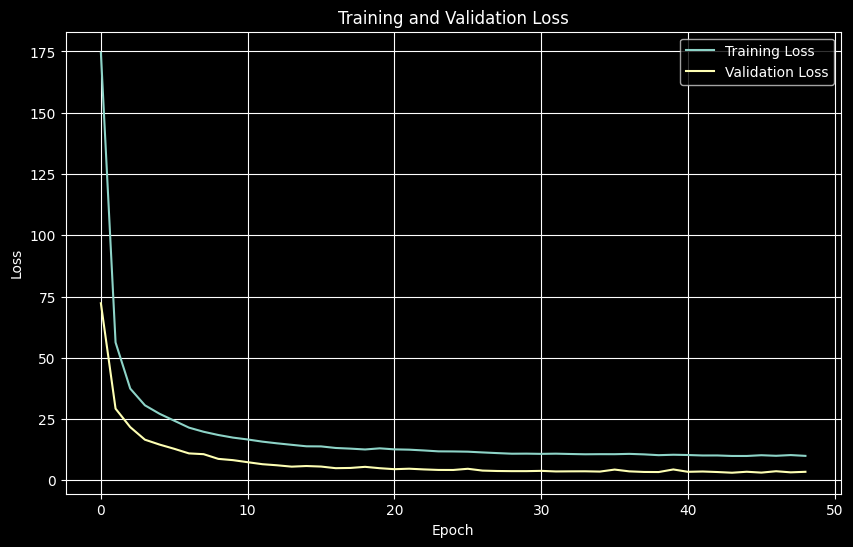

In [12]:
file_names = os.listdir("../Processed-Data/Pedigree-Results")
file_paths = list(map(lambda x: "../Processed-Data/Pedigree-Results/" + x, file_names))

# データの分割
train_paths, test_paths = train_test_split(file_paths, test_size=0.3)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2)

# データセットの作成
train_dataset = PedigreeDataset(train_paths)
val_dataset = PedigreeDataset(val_paths)
test_dataset = PedigreeDataset(test_paths)

# データローダーの設定
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(
    input_dim=226,
    hidden_dim=147,
    latent_dim=30,
    num_layers=2,
    dropout=0.2088016451903072,
)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.009785938947748174)


# エポック数
num_epochs = 200

# 評価を行うエポック数
eval_interval = 5

# 誤差を記録するリスト
train_losses = []
val_losses = []

# Early Stopping用のパラメータ
best_val_loss = float("inf")
patience_counter = 0
min_improvement = 0.005  # n%の改善を期待
patience = 5  # n回連続で改善が見られない場合に停止

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_data = batch.to(device)

        optimizer.zero_grad()
        _, recon_batch = model(input_data)
        loss = ae_loss(recon_batch, input_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # エポックごとの平均誤差を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 検証データセットでモデルを評価
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_input = val_batch.to(device)
            _, recon_batch = model(val_input)
            loss = ae_loss(recon_batch, val_input)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Early Stopping判定
    if avg_val_loss < best_val_loss * (1 - min_improvement):
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if epoch % eval_interval == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

# 実際に実行されたエポック数
final_epoch = len(train_losses)

# 学習曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(range(final_epoch), train_losses, label="Training Loss")
plt.plot(range(final_epoch), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
model.eval()
test_loss = 0
with torch.no_grad():
    for test_batch in test_loader:
        test_input = test_batch.to(device)
        _, recon_batch = model(test_input)
        loss = ae_loss(recon_batch, test_input)
        test_loss += loss.item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")

Test Loss: 10.111261991165115


In [14]:
torch.save(model.state_dict(), "../models/v2/pedigree_result_AE.pth")

### 確認

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(
    input_dim=226,
    hidden_dim=147,
    latent_dim=30,
    num_layers=2,
    dropout=0.2088016451903072,
)
model.to(device)

model.load_state_dict(torch.load("../models/v2/pedigree_result_AE.pth"))
model.eval()

file_names = os.listdir("../Processed-Data/Pedigree-Results")
file_paths = list(map(lambda x: "../Processed-Data/Pedigree-Results/" + x, file_names))
df = pd.read_pickle(file_paths[0])
sample = df.sample()

# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(sample.values, dtype=torch.float32).to(device)
# 潜在変数の取得
with torch.no_grad():
    encoded = model.encode(data)

print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 226])
潜在変数サイズ: torch.Size([1, 30])

潜在変数:
[[-0.11368093  0.7673588   0.4479838  -0.05648721 -0.7605405  -1.2456082
  -0.5125762  -0.7271226  -0.6539228  -0.02064242 -0.6368032   0.39888543
  -0.6488458  -0.39746988 -0.23889828 -0.5723997   0.8611027  -1.1063564
   0.7069073  -0.0886189   0.42451692 -0.03541993  0.0981581   0.01274082
   1.3845228  -0.49489295  0.22983176 -0.1712031   0.45777923  0.37792858]]
